In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from T2T_ACE.alignment_utilities import load_reference
import T2T_ACE.validator as v
import importlib

In [2]:
# Update the reference genomes to local path
class ReferenceLocations:
        hg002t2t = "/Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta"
        chm13 = "/Users/gaoyueya/Documents/Reference_Genome/chm13v2.0.fa.gz"
        hg38 = "/Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta"

# Load the minimap2 aligner from reference fasta file
# Load HG002 T2T reference
hg002t2t = load_reference(ReferenceLocations.hg002t2t)
# Load hg38 reference
hg38 = load_reference(ReferenceLocations.hg38)

INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta
INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta


In [3]:
# Load DRAGEN CNV output
HG2_DRAGEN_cnv_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1639/DRAGEN4_2_4_visualization/DRAGEN_Output/NA24385.cnv_sv.vcf"
def read_vcf(vcf_path):
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df
HG2_DRAGEN_cnv = read_vcf(HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
HG2_DRAGEN_pass_cnv.head()
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DEL_pass_intervals = []
DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DUP_pass_intervals.append(interval)
print('HG2 DEL intervals:',len(DEL_pass_intervals))
print('HG2 DUP intervals:',len(DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [151]:
# This function is to calculate distance between DEL flankings
def distance_between_flankings(del_interval, flanking_size=1000):
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    
    # Create flanking intervals for the deletion interval
    # The flanking size is 10% of the SV length
    if flanking_size:
        flanking_size = flanking_size
    else:
        if svlen < 1000:
            flanking_size = 1000
        else:
            flanking_size = int(svlen * 0.1)
    
    left_flanking_pos = pos - flanking_size
    left_flanking_end = pos 
    right_flanking_pos = end
    right_flanking_end = end + flanking_size
    
    left_flanking_interval = v.create_interval(chr, left_flanking_pos, left_flanking_end)
    right_flanking_interval = v.create_interval(chr, right_flanking_pos, right_flanking_end)
    print("left_flanking_interval:", left_flanking_interval, v.interval_size(left_flanking_interval))
    print("right_flanking_interval:", right_flanking_interval, v.interval_size(right_flanking_interval))
    
    # Align the flanking intervals to the reference genome
    left_flanking_interval_aligned = v.align_interval(left_flanking_interval, ReferenceLocations.hg38, hg38, hg002t2t)
    right_flanking_interval_aligned = v.align_interval(right_flanking_interval, ReferenceLocations.hg38, hg38, hg002t2t)
    
    # Grab intervals of flanking region alignments
    left_flanking_alignment_intervals = [interval for interval, strand, q_start, q_end in left_flanking_interval_aligned[1]]
    right_flanking_alignment_intervals = [interval for interval, strand, q_start, q_end in right_flanking_interval_aligned[1]]
    
    distance_between_flankings_list = []
    for left_flanking_interval, strand, q_start, q_end in left_flanking_interval_aligned[1]:
        if strand ==1:
            matching_right_flanking_interval = v.find_next_interval(left_flanking_interval, right_flanking_alignment_intervals)
            distance_between_flankings = v.distance_between_intervals(left_flanking_interval, matching_right_flanking_interval)
            distance_between_flankings_list.append(distance_between_flankings)
            if distance_between_flankings < int(svlen) * 0.5:
                print('********** Potential DEL **********')
            else:
                print("----------- No DEL Evidence -----------")
            print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")
        elif strand == -1:
            matching_right_flanking_interval = v.find_previous_interval(left_flanking_interval, right_flanking_alignment_intervals)
            distance_between_flankings = v.distance_between_intervals(left_flanking_interval, v.find_previous_interval(left_flanking_interval, right_flanking_alignment_intervals))
            distance_between_flankings_list.append(distance_between_flankings)
            if distance_between_flankings < int(svlen) * 0.5:
                print('********** Potential DEL **********')
            else:
                print("----------- No DEL Evidence -----------")
            print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")
    return distance_between_flankings_list


In [152]:
def classify_del(del_interval, flanking_size=1000): 
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    print(del_interval, svlen)
    distance_between_flankings_list = distance_between_flankings(del_interval, flanking_size)
    if chr == 'chrY' or chr == 'chrX':
        if len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Homozygous DEL'
        elif len(distance_between_flankings_list)>0 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Heterozygous DEL'
        else:
            return 'Unknown'
    elif len(distance_between_flankings_list) > 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Complex DEL'
    elif len(distance_between_flankings_list) == 2 and distance_between_flankings_list[0] <= svlen*0.5 and distance_between_flankings_list[1] <= svlen*0.5:
        return 'Homozygous DEL'
    elif len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Heterozygous DEL'
    else:
        return 'Unknown'


In [153]:
# Example 1: Homozygous deletion (Needs basepair correction)
classify_del(DEL_pass_intervals[0])

chr1:934321-934937 617
left_flanking_interval: chr1:933321-934321 1001
right_flanking_interval: chr1:934937-935937 1001
********** Potential DEL **********
chr1_MATERNAL:366927-367768 (842bp), chr1_MATERNAL:367706-368706 (1001bp), -63
********** Potential DEL **********
chr1_PATERNAL:367566-368407 (842bp), chr1_PATERNAL:368345-369345 (1001bp), -63


'Homozygous DEL'

In [154]:
# Example 2: Heterozygous deletion (No basepair correction is needed)
classify_del(DEL_pass_intervals[1])

chr1:1934923-1935584 662
left_flanking_interval: chr1:1933923-1934923 1001
right_flanking_interval: chr1:1935584-1936584 1001
----------- No DEL Evidence -----------
chr1_MATERNAL:1371206-1372207 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 659
********** Potential DEL **********
chr1_PATERNAL:1377138-1378207 (1070bp), chr1_PATERNAL:1378207-1379207 (1001bp), -1


'Heterozygous DEL'

In [155]:
# Example 3: Het deletion with complex structure (Needs basepair correction)
classify_del(DEL_pass_intervals[2])

chr1:1934989-1935584 596
left_flanking_interval: chr1:1933989-1934989 1001
right_flanking_interval: chr1:1935584-1936584 1001
----------- No DEL Evidence -----------
chr1_MATERNAL:1371272-1372273 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 593
********** Potential DEL **********
chr1_PATERNAL:1377204-1378225 (1022bp), chr1_PATERNAL:1378207-1379207 (1001bp), -19


'Heterozygous DEL'

In [82]:
classify_del_list = []
flanking_distance_list = []
for del_interval in DEL_pass_intervals:
    print(del_interval, v.interval_size(del_interval))
    flanking_distance_list.append(distance_between_flankings(del_interval))
    classify_del_list.append(classify_del(del_interval))
    

chr1:934321-934937 617
* chr1_MATERNAL:366927-367768 chr1_MATERNAL:367706-368706 -63
* chr1_PATERNAL:367566-368407 chr1_PATERNAL:368345-369345 -63
* chr1_MATERNAL:366927-367768 chr1_MATERNAL:367706-368706 -63
* chr1_PATERNAL:367566-368407 chr1_PATERNAL:368345-369345 -63
chr1:1934923-1935584 662
chr1_MATERNAL:1371206-1372207 chr1_MATERNAL:1372867-1373870 659
* chr1_PATERNAL:1377138-1378207 chr1_PATERNAL:1378207-1379207 -1
chr1_MATERNAL:1371206-1372207 chr1_MATERNAL:1372867-1373870 659
* chr1_PATERNAL:1377138-1378207 chr1_PATERNAL:1378207-1379207 -1
chr1:1934989-1935584 596
chr1_MATERNAL:1371272-1372273 chr1_MATERNAL:1372867-1373870 593
* chr1_PATERNAL:1377204-1378225 chr1_PATERNAL:1378207-1379207 -19
chr1_MATERNAL:1371272-1372273 chr1_MATERNAL:1372867-1373870 593
* chr1_PATERNAL:1377204-1378225 chr1_PATERNAL:1378207-1379207 -19
chr1:2122128-2124374 2247
chr1_MATERNAL:1559833-1560058 chr1_MATERNAL:1562707-1562932 2648
chr1_MATERNAL:1559833-1560058 chr1_MATERNAL:1562707-1562932 2648
chr1:

In [83]:
DEL_classification_df = pd.DataFrame()
DEL_classification_df['DEL_interval'] = DEL_pass_intervals
DEL_classification_df['DEL_size'] = [v.interval_size(interval) for interval in DEL_pass_intervals]
DEL_classification_df['DEL_classification'] = classify_del_list
DEL_classification_df['flanking_distance'] = flanking_distance_list
DEL_classification_df.head()

,DEL_interval,DEL_size,DEL_classification,flanking_distance
0,chr1:934321-934937,617,Homozygous DEL,"[-63, -63]"
1,chr1:1934923-1935584,662,Heterozygous DEL,"[659, -1]"
2,chr1:1934989-1935584,596,Heterozygous DEL,"[593, -19]"
3,chr1:2122128-2124374,2247,Unknown,[2648]
4,chr1:6006003-6006574,572,Heterozygous DEL,"[75, 1178]"


In [85]:
DEL_classification_df['DEL_classification'].value_counts()

DEL_classification
Heterozygous DEL    551
Homozygous DEL      313
Unknown              82
Complex DEL          50
Name: count, dtype: int64

In [68]:
DEL_classification_df.to_csv('HG2_DRAGEN_DEL_classification.csv', index=False)

In [127]:
DEL_classification_df[DEL_classification_df['DEL_classification'] == 'Unknown']

,DEL_interval,DEL_size,DEL_classification,flanking_distance
3,chr1:2122128-2124374,2247,Unknown,[2648]
5,chr1:13235347-13240700,5354,Unknown,"[5325, 5320, 5368]"
11,chr1:25258201-25284564,26364,Unknown,"[26355, 26353]"
47,chr1:169257422-169273108,15687,Unknown,[15674]
57,chr1:203918538-203920758,2221,Unknown,[2445]
...,...,...,...,...
932,chr21:10570658-10660041,89384,Unknown,"[89418, 89373, 89357, 89342]"
933,chr21:10738110-10788186,50077,Unknown,"[50072, 50072, 50072, 48986, 49476, 49478]"
953,chr22:23936381-23937901,1521,Unknown,[1523]
989,chrX:155803598-155984222,180625,Unknown,"[183368, 183364]"


In [158]:
classify_del("chr1:2122128-2124374",2000)

chr1:2122128-2124374 2247
left_flanking_interval: chr1:2120128-2122128 2001
right_flanking_interval: chr1:2124374-2126374 2001
----------- No DEL Evidence -----------
chr1_MATERNAL:1558057-1560058 (2002bp), chr1_MATERNAL:1562707-1564708 (2002bp), 2648
----------- No DEL Evidence -----------
chr1_PATERNAL:1563086-1565305 (2220bp), chr1_PATERNAL:1567007-1569007 (2001bp), 1701


'Unknown'

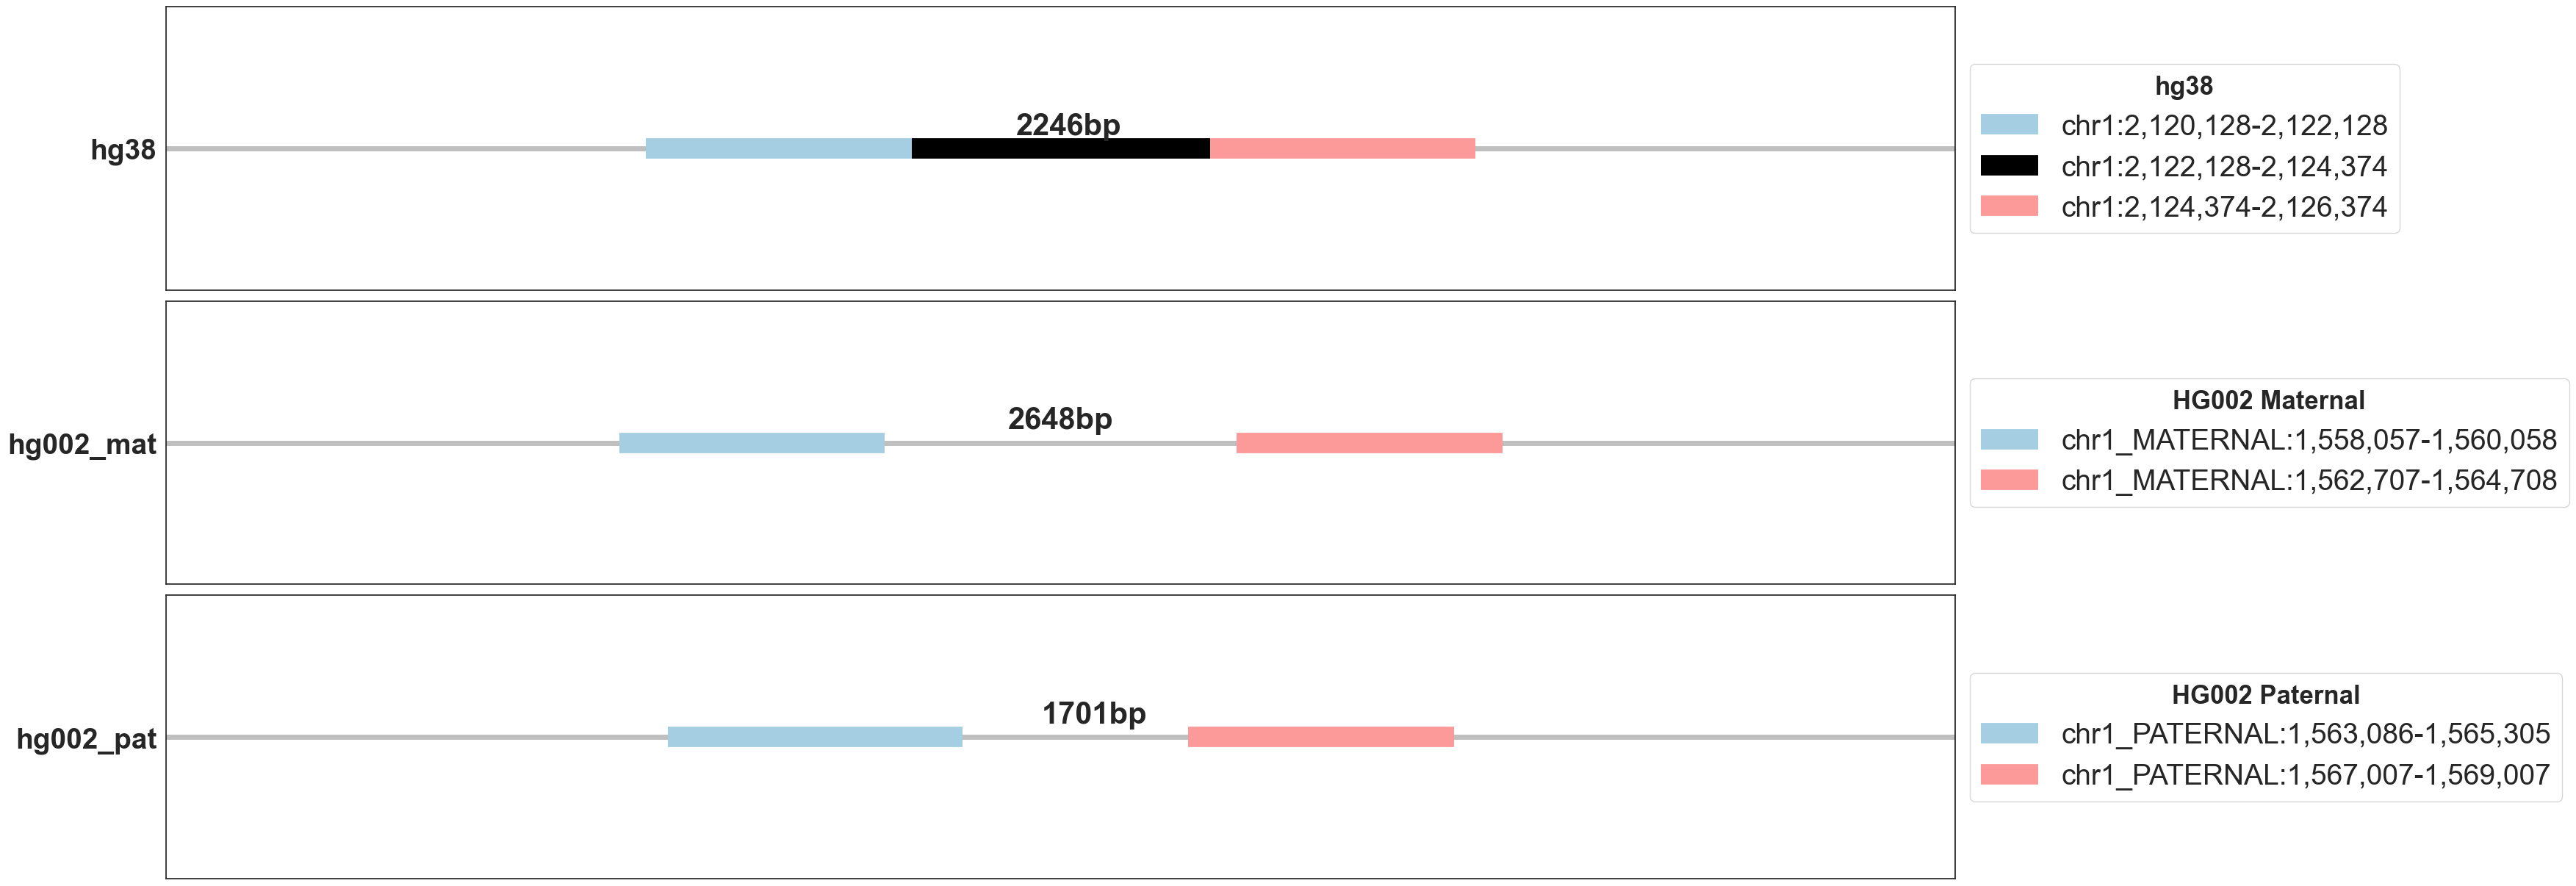

In [166]:
import T2T_ACE.alignment_visualization_utilities as avu
importlib.reload(avu)
avu.PlotIntervals(["chr1:2122128-2124374", "chr1:2120128-2122128", "chr1:2124374-2126374"], ["chr1_MATERNAL:1558057-1560058","chr1_MATERNAL:1562707-1564708","chr1_PATERNAL:1563086-1565305", "chr1_PATERNAL:1567007-1569007"]).plot_intervals_comparison(flanking=True, save=True, savepath='/Users/gaoyueya/Documents/GitHub/T2T-ACE/docs/')

In [ ]:
# TODO: 1. 0 bp between flanking intervals doesn't always there is a DEL. Need to update the code to check if there is a matching flanking region. 
# TODO: 2. Check if all unknown DELs are FPs. If not FPs, what are they?
# TODO: 3. Analyze the complex DELs. So far, it seems like the complex DELs are DEL in DUP. I want to check if this is true. 
# TODO: 4. Develop basepair correction for DELs.
# TODO: 5. The current basepair correction mechanism seems to have flaws. The extended copies are overlapping with each other. Need to fix this.